In [1]:
from dotenv import load_dotenv
from typing import Annotated, TypedDict, Literal,List

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch

# Control model : gpt-4.1-mini
ctrl_llm = ChatOpenAI(
    model_name='gpt-4.1-mini',
    temperature=0
)

# Agent model : gpt-4o
agent_llm = ChatOpenAI(
    model_name='gpt-4o',
    temperature=0
)

search_tool = TavilySearch(max_results=3)
TOOLS = [search_tool]

In [3]:
from langgraph.graph.message import add_messages

class State(TypedDict, total=False):
    # 사용자의 첫 질문
    question: str 
    
    # 대화 기록 
    messages: Annotated[list, add_messages]
    
    # plan 노드에서 만든 단계별 계획
    plan: str
    
    # 현재 그래프가 진행 중인 단계
    status: Literal['planning', 'acting', 'replanning', 'done']
    
    # 현재의 반복 진행 수
    step: int
    
    # 최대 반복 횟수
    max_iters: int
    
    # 전체 과정을 log화
    log: List[str]
    
    # 최종 결과
    report: str

In [4]:
# 상태 State 에 실행 로그를 추가
def _log(state: State, message: str) -> None:
    state.setdefault("log", []).append(message)

In [5]:
# 1. Planner 노드
from langchain_core.prompts import ChatPromptTemplate

planner_system_prompt = (
    """
        # Role
        너는 사업 분석에 능통하고, DB를 잘 이해하는 DBA야
        
        # Context
        
        # Rule
        - 1. 크게 4단계로 나누어서 계획을 수립해줘
        -- (1) db 스키마 및 컬럼 분석
        -- (2) 분석에 필요한 쿼리 생성
        -- (3) 쿼리 실행 결과
        -- (4) (1) + (3) 결과를 조합한 분석
    """
)

def planner_node(state: State) -> State:
    
    question = state.get('question', '')
    
    prompt = ChatPromptTemplate.from_messages([
        ('system', planner_system_prompt),
        ('user', f'[목표] : {question}\n\n 계획 섹션만 마크다운으로 작성')
    ])
    
    response = ctrl_llm.invoke(prompt.format_messages())
    new = {**state, 'plan': response.content, 'status': 'planning', 'step': state.get('step', 0)}
    new.setdefault('messages', []).append(response)
    _log(new, '[planner] 계획 설정')
    
    return new

In [6]:
# 2. Agent 노드
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(agent_llm, TOOLS)

def agent_node(state: State) -> State:
    
    agent_system_prompt = (
    """
        # Role
        너는 사업 분석에 능통하고, DB를 잘 이해하는 DBA야
        
        # Context
        
        # Rule
        가지고 있는 plan 단계에 따라서 필요한 행동을 가지고 있는 tool을 가지고 수행
    """
    )
    
    messages = [("system", agent_system_prompt), *state.get("messages", [])] 
    response = agent.invoke({"messages", messages})
    
    new = {**state, "status": 'acting'}
    new.setdefault('messages', []).extend(response['messages'])
    _log(new, '[agent] 행동/응답')
    
    return new

In [7]:
# 3. Tool 노드
from langgraph.prebuilt import ToolNode

tools_node = ToolNode(TOOLS)

replan_system_prompt = (
    """
        # Role
        당신은 Replanner입니다. 직전 도구/에이전트 결과를 분석해서 다음 행동을 지시하세요
        
        # Rule
        1. 충분한 근거가 모였으면 '종료'를 선언
        2. 아니면 다음 검색/행동을 지시
    """
)

def replan_node(state: State) -> State:
    
    messages = state.get('messages', [])
    
    response = ctrl_llm.invoke([
        #{'role': 'system', 'content' : replan_system_prompt}
        ('system', replan_system_prompt),
        *messages,
        ('user', '지금 상태에서 종료 또는 다음 행동을 지시해')
    ])
    
    text = response.content
    
    done = ('종료' in text) or ('충분' in text and '근거' in text)
    
    if done:
        new['status'] = 'done'
    
    new = {**state}
    new.setdefault('messages', []).append(response)
    
    current_step = int(state.get('step', 0)) + 1
    new['step'] = current_step
    
    return new 

In [8]:
# 4. Final 노드

final_system_prompt = (
    """
    지금까지 대화/검색 내용을 바탕으로 최종 리포트를 작성하세요
    핵심 포인트 -> 리스크/기회 -> 참고 자료 요약
    """
)

def final_node(state: State):
    
    messages = state.get('messages', [])
    response = ctrl_llm.invoke([
        ('system', final_system_prompt),
        *messages
    ])
    
    new = {**state, 'report': response.content, 'status' : 'done'}
    new.setdefault('messages', []).append(response)
    _log(new, '[final] 최종 리포트 생성')
    
    return new 

In [9]:
# 5. 랭그래프 생성
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage

builder = StateGraph(State)

In [10]:
builder.add_node('planner', planner_node)
builder.add_node('agent', agent_node)
builder.add_node('tools', tools_node)
builder.add_node('replan', replan_node)
builder.add_node('final', final_node)

In [11]:
# 항상 연결 node(실선)
builder.add_edge(START, 'planner')
builder.add_edge('planner', 'agent')
builder.add_edge('tools', 'replan')

In [12]:
# 조건부 연결 node(점선)
def router_agent(state: State):
    
    messages = state.get('messages', [])
    if not messages:
        return 'final'
    
    last = messages[-1]
    if getattr(last, 'tool_calls', None):
        return 'tools'
    
    return 'final'

builder.add_conditional_edges('agent', router_agent, {'tools': 'tools', 'final': 'final'})

def router_replan(state: State):
    
    if state.get('status') == 'done':
        return 'final'
    else: 
        return 'agent'
    
builder.add_conditional_edges('replan', router_replan, {'agent': 'agent', 'final': 'final'})

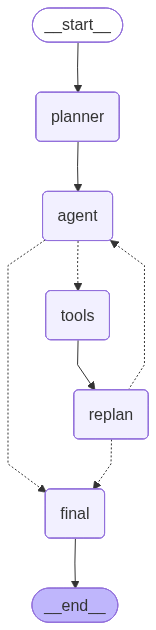

In [13]:
graph = builder.compile()
graph